# Objective of the project and Context

The aim of this project is to predict the number of reservations restaurants are likely to have basis historical data. The data is for the country of Japan.

Further details about the data and the processes are mentioned below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set_style("darkgrid")
import math
from math import sqrt

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

######################################################################################################################

### Creating some necessary functions

In [2]:
## Custom one-hot encoder
def one_hot_encode(df, categorical_col_list, drop_column):
    for col in categorical_col_list:
        dummies = pd.get_dummies(df[col])
        dummies = dummies.add_suffix('_' + str(col))
        df = pd.concat([df, dummies], axis=1)
        
        if drop_column == "yes": df = df.drop(columns=[col])
    return df

In [3]:
## Genre binning function
def assign_genre_category(i):
    if i > 5.0: return "G1"
    if 5.0 > i > 2.0: return "G2"
    if 2.0 > i > 1.0: return "G3"
    if i == 1.0: return "G4"
    if 1.0 > i > 0.5: return "G5"
    if 0.5 > i > 0.1: return "G6"
    else: return "G7"

In [4]:
## Area binning function
def assign_area_category(i):
    if i > 2: return "A1"
    if 2 > i > 1.5: return "A2"
    if 1.5 > i > 1.2: return "A3"
    if 1.2 > i > 1: return "A4"
    if i == 1.0: return "A5"
    if 1.0 > i > 0.5: return "A6"
    if 0.5 > i > 0.1: return "A7"
    else: return "A8"

######################################################################################################################

## Introduction to Data

#### "hpg_reserve.csv"
This file contains 
- store indentifier
- time of visit
- time of reservation
- the number of reservations.

For this exploration, we'll use reserve_visitors as our independent variable (target_variable).

This data is from 2016 and upto March 2017. We'll use 2016 data for training and 3 months of 2017 data for predictions.

In [5]:
df = pd.read_csv("hpg_reserve.csv")
df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


#### "hpg_store_info.csv"

This file contains 
- store indentifier
- store genre
- area where the store is located
- and approximate coordinates of the store (last 2 columns).

In [6]:
df_info = pd.read_csv("hpg_store_info.csv")
df_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


#### "date_info.csv"

This file contains information regarding the dates: day of the week and holiday occurance. The columns are self-explanatory.

In [7]:
date_info = pd.read_csv("date_info.csv")
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,01-01-16,Friday,1
1,02-01-16,Saturday,1
2,03-01-16,Sunday,1
3,04-01-16,Monday,0
4,05-01-16,Tuesday,0


## Data Preprocessing, Visualization & Preparation

- Merging store attributes, converting datetime columns in proper format.
- Treating null values for genre and area columns. Since no restaurant can be without genre or location, absence of proper information can be imputed with "Other" tag.
- Reducing the dataframe to single date per restaurant level

- Visualizing the predictive power of genre of the restaurants and the areas where they are.

In [8]:
df = df.merge(df_info, on="hpg_store_id", how="left")
df["calendar_date"] = pd.to_datetime(df.visit_datetime)
df = df.drop(columns=["visit_datetime", "reserve_datetime"])
df["hpg_genre_name"] = df["hpg_genre_name"].fillna("Other")
df["hpg_area_name"] = df["hpg_area_name"].fillna("Other")

df = df.groupby(list(df.columns.drop("reserve_visitors")))["reserve_visitors"].sum().reset_index()
df = df.sort_values(by=["hpg_store_id", "calendar_date"])

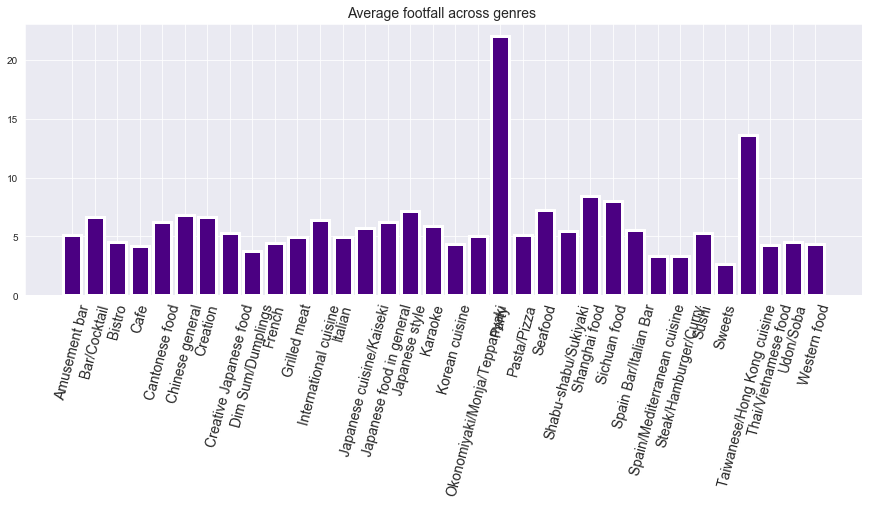

In [9]:
x = df.groupby(['hpg_genre_name'])['reserve_visitors'].mean().reset_index()

plt.figure(figsize=(15,5))
plt.bar(x['hpg_genre_name'], x['reserve_visitors'], color="indigo", linewidth=3)
plt.xticks(fontsize=14, rotation=75)
# plt.yticks(fontsize=14, rotation=0)
plt.title("Average footfall across genres ", fontsize=14)
plt.show()

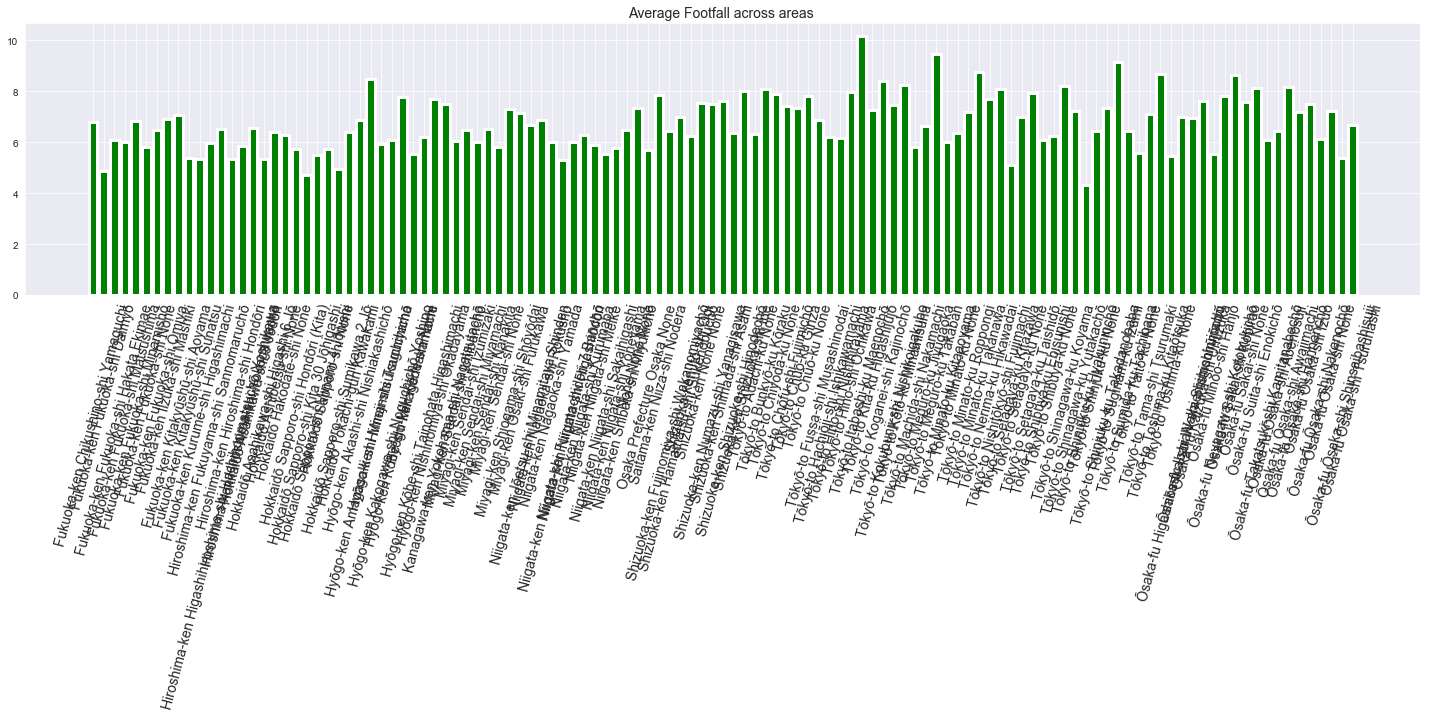

In [10]:
x = df.groupby(['hpg_area_name'])['reserve_visitors'].mean().reset_index()

plt.figure(figsize=(25,5))
plt.bar(x['hpg_area_name'], x['reserve_visitors'], color="green", linewidth=3)
plt.xticks(fontsize=14, rotation=75)
# plt.yticks(fontsize=14, rotation=0)
plt.title("Average Footfall across areas ", fontsize=14)
plt.show()

### Preparing genre and area features for the prediction.

It is clear that the reservations vary widely across genres, however less so across areas. This is not surprising given that Japan is very densely populated country and people live in dense cities.

Since the number of genres and the areas is very large, and especially because certain groups of genres and areas have more predictive power compared to others, it may not be sensible to simply one-hot encode them.

Our approach will be to bin the genres and areas into 7 & 8 buckets, respectively, and one-hot encode these bins. These buckets will be defined by the total popularity of these genres, ie, the total sums of reservations they have. Once the sums are calculated, we'll see how far they are from the means and try to put them in respective ranges.

- For genre, bins will be: G1, G2, G3... G7.
- For areas, A1, A2, A3,... A8.

Custom functions to do that are defined above in the beginning of the notebook.

In [11]:
genre_df = df.groupby(["hpg_genre_name"])["reserve_visitors"].sum().reset_index()
genre_df["genre_mean_ratio"] = np.round(genre_df["reserve_visitors"]/(np.mean(genre_df["reserve_visitors"])), 4)
genre_df.loc[genre_df["hpg_genre_name"] == "Other", "genre_mean_ratio"] = 1

genre_df['genre_category'] = genre_df['genre_mean_ratio'].apply(assign_genre_category)
genre_codes_dict = genre_df[["hpg_genre_name", "genre_category"]].set_index('hpg_genre_name').T.to_dict('list')
df["hpg_genre_name"] = [i[0] for i in df["hpg_genre_name"].map(genre_codes_dict)]
df = pd.get_dummies(df, columns=["hpg_genre_name"], prefix="hpg_genre_name")

area_df = df.groupby(["hpg_area_name"], as_index=False).agg({"reserve_visitors":"sum"})
area_df["area_mean_ratio"] = np.round(area_df["reserve_visitors"]/(np.mean(area_df["reserve_visitors"])), 4)
area_df.loc[area_df["hpg_area_name"] == "Other", "area_mean_ratio"] = 1
area_df = area_df.sort_values(by="area_mean_ratio", ascending=False)

area_df['area_category'] = area_df['area_mean_ratio'].apply(assign_area_category)
area_codes_dict = area_df[["hpg_area_name", "area_category"]].set_index('hpg_area_name').T.to_dict('list')
df["hpg_area_name"] = [i[0] for i in df["hpg_area_name"].map(area_codes_dict)]
df = pd.get_dummies(df, columns=["hpg_area_name"], prefix="hpg_area_name")

df["calendar_date"] = pd.to_datetime(df["calendar_date"])
df.head()

,hpg_store_id,latitude,longitude,calendar_date,reserve_visitors,hpg_genre_name_G1,hpg_genre_name_G2,hpg_genre_name_G3,hpg_genre_name_G5,hpg_genre_name_G6,hpg_genre_name_G7,hpg_area_name_A1,hpg_area_name_A2,hpg_area_name_A3,hpg_area_name_A4,hpg_area_name_A6,hpg_area_name_A7,hpg_area_name_A8
0,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-01-13 18:00:00,4,1,0,0,0,0,0,1,0,0,0,0,0,0
1,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-01-27 19:00:00,7,1,0,0,0,0,0,1,0,0,0,0,0,0
2,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-02-13 17:00:00,2,1,0,0,0,0,0,1,0,0,0,0,0,0
3,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-02-27 18:00:00,8,1,0,0,0,0,0,1,0,0,0,0,0,0
4,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-03-16 19:00:00,2,1,0,0,0,0,0,1,0,0,0,0,0,0


### Preparing datetime features and visualizing their predictive power

We'll create 6 datetime related features, listed below.

- year (will not visualize, only for segregation)
- month
- day
- weekday
- week
- weekend (will not visualize, necessity is obvious)

In [12]:
df["year"] = df.calendar_date.dt.year
df["month"] = df.calendar_date.dt.month
df["day"] = df.calendar_date.dt.day
df["weekday"] = df.calendar_date.dt.weekday + 1

df["week"] = df.calendar_date.dt.weekofyear
df["week"] = df["week"].map(lambda x: 1 if x > 52 else x)
df["calendar_date"] = df["calendar_date"].dt.date
df['weekend'] = np.where(df["weekday"].isin([6,7]) == True, 1, 0)
df.head()

,hpg_store_id,latitude,longitude,calendar_date,reserve_visitors,hpg_genre_name_G1,hpg_genre_name_G2,hpg_genre_name_G3,hpg_genre_name_G5,hpg_genre_name_G6,...,hpg_area_name_A4,hpg_area_name_A6,hpg_area_name_A7,hpg_area_name_A8,year,month,day,weekday,week,weekend
0,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-01-13,4,1,0,0,0,0,...,0,0,0,0,2016,1,13,3,2,0
1,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-01-27,7,1,0,0,0,0,...,0,0,0,0,2016,1,27,3,4,0
2,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-02-13,2,1,0,0,0,0,...,0,0,0,0,2016,2,13,6,6,1
3,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-02-27,8,1,0,0,0,0,...,0,0,0,0,2016,2,27,6,8,1
4,hpg_001ce40a1f873e4f,34.692109,135.191698,2016-03-16,2,1,0,0,0,0,...,0,0,0,0,2016,3,16,3,11,0


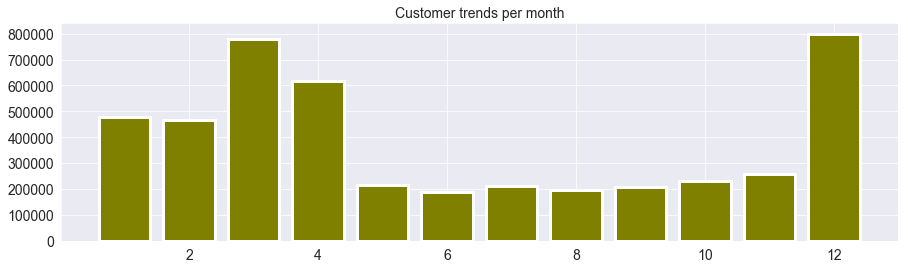

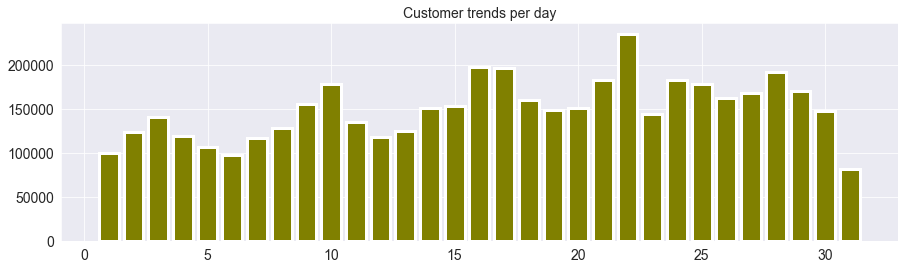

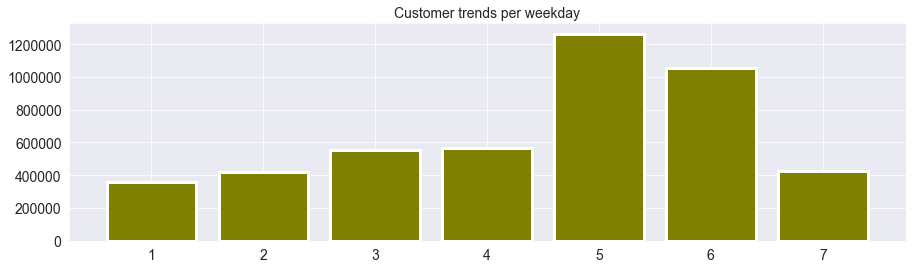

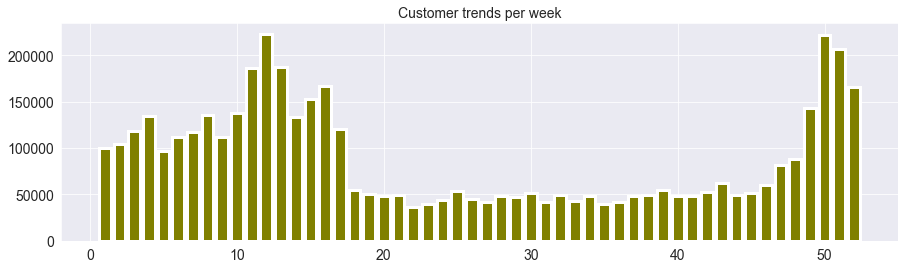

In [13]:
for i in ["month", "day", "weekday", "week"]:
    
    df_1 = df.groupby([i], as_index=False).agg({"reserve_visitors":"sum"})
    plt.figure(figsize=(15,4))
    
    plt.bar(df_1[df_1.columns[0]], df_1[df_1.columns[1]], color="olive", linewidth=3)
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    plt.title("Customer trends per " + i, fontsize=14)
    plt.show()

From the above plots its clear that all of these datetime features have significant predictive value.


### Outlier Catch

A second important observation can be made from the last graph, which plots the number of reservations per week. Here, in the weeks of the December month and the March month.

The 50th week and the 12th week - the last week of March have abnormally high reservations. They are clearly outliers. But they cannot be thrown out because they are not noise.

- The 50th week, being the week just before Christmas is obviously going to have very high restaurant visits.
- Also, the last week of March - again - is the close of the Japanese financial year, implying country wide holiday and consequently high visits.

### Outlier Treatment

This means we cannot remove these data points. So, in order to make our forecasting models more robust to these outliers, we'll do a log transformation on our target column.

In [14]:
df["reserve_visitors"] = np.log(df["reserve_visitors"])

### Consuming holiday information

The date_info data which contains information whether a certain date is a holiday or not, can be used to calcualte a couple of features:

- If a certain day is a holiday, it is very reasonable that the day previous to that will receive a larger number of reservations. So, we'll create a flag indicating whether a certain date follows a holiday or not.
- Also, if we look at our week vs reservations graph, we can see that higher number of reservations, closely connected to holidays and festive season, take a few days to taper town. So we'll create a flag indicating whether a certain date was followed by a holiday or not.

In [15]:
date_info = date_info[["calendar_date", "holiday_flg"]]
date_info["calendar_date"] = pd.to_datetime(date_info.calendar_date)
date_info['day_before_holiday'] = date_info['holiday_flg'].shift().fillna(0)
date_info['day_after_holiday'] = date_info['holiday_flg'].shift(-1).fillna(0)

df["calendar_date"] = pd.to_datetime(df.calendar_date)
df = df.merge(date_info, on="calendar_date", how="left")
df["holiday_flg"] = df["holiday_flg"].fillna(0)
df[["day_before_holiday", "day_after_holiday"]] = df[["day_before_holiday", "day_after_holiday"]].fillna(0)

df = df.drop(columns=["latitude", "longitude", "calendar_date"])
df.head()

,hpg_store_id,reserve_visitors,hpg_genre_name_G1,hpg_genre_name_G2,hpg_genre_name_G3,hpg_genre_name_G5,hpg_genre_name_G6,hpg_genre_name_G7,hpg_area_name_A1,hpg_area_name_A2,...,hpg_area_name_A8,year,month,day,weekday,week,weekend,holiday_flg,day_before_holiday,day_after_holiday
0,hpg_001ce40a1f873e4f,1.386294,1,0,0,0,0,0,1,0,...,0,2016,1,13,3,2,0,0.0,0.0,0.0
1,hpg_001ce40a1f873e4f,1.945910,1,0,0,0,0,0,1,0,...,0,2016,1,27,3,4,0,0.0,0.0,0.0
2,hpg_001ce40a1f873e4f,0.693147,1,0,0,0,0,0,1,0,...,0,2016,2,13,6,6,1,0.0,0.0,0.0
3,hpg_001ce40a1f873e4f,2.079442,1,0,0,0,0,0,1,0,...,0,2016,2,27,6,8,1,0.0,0.0,0.0
4,hpg_001ce40a1f873e4f,0.693147,1,0,0,0,0,0,1,0,...,0,2016,3,16,3,11,0,0.0,0.0,0.0


## Building our forecasting model

### Train Test Split

Dividing the data according to the year and computing.

We will not use the datetime features in timeseries methods, rather use regression methods only.

In [16]:
train = df.query('year == 2016')
test = df.query('year == 2017')

train = train.drop(columns=["year", "hpg_store_id"])
test = test.drop(columns=["year", "hpg_store_id"])

print(train.shape)
print(test.shape)

(477677, 22)
(252306, 22)


### First Approach: Linear Regression

**Choice of error metric**: Since we are treating it as a regression problem, we can use MAE, MSE, RMSE, RMSLE, etc.

We will go with **RMSLE - Root Mean Square Logarithmic Error**. We will do that because RMSLE, compared to RMSE, etc penalizes the underestimations by the model more than overestimations. And for a restaurant, it is more problematic if they plan staff and resources for less reservations but actually receive more than it is the other way round.

In [17]:
lr = LinearRegression()

lr.fit(train[train.columns.drop(["reserve_visitors"])], train["reserve_visitors"])

train_predictions = lr.predict(train[train.columns.drop(["reserve_visitors"])])
test_predictions = lr.predict(test[test.columns.drop(["reserve_visitors"])])

# Some of the predictions were -ve. Just limiting them to 0.
train_predictions = np.where(train_predictions < 0, 0, train_predictions)
test_predictions = np.where(test_predictions < 0, 0, test_predictions)

print(sqrt(mean_squared_log_error(train["reserve_visitors"], train_predictions)))
print(sqrt(mean_squared_log_error(test["reserve_visitors"], test_predictions)))

0.2941586759618151
0.3018362054026489


### Observations and Conclusions

- The train and test RMSLE are not very far apart.
- The test RMSLE is quite acceptable from a business perspective.

Following conclusions can be drawn:
- Since the train and test errors are not very different and both are actually quite low, the model has low bias and only slightly more variance.
- There is not much overfitting or underfitting.

While the linear regression approach is giving decent results, lets look at RandomForest algorithm and see if they improve our predictions.

### Second Approach: Random Forests

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Currently going with most parameters as default
rf = RandomForestRegressor(min_samples_leaf=100, max_features=5)

rf.fit(train[train.columns.drop(["reserve_visitors"])], train["reserve_visitors"])
train_predictions = rf.predict(train[train.columns.drop(["reserve_visitors"])])
test_predictions = rf.predict(test[test.columns.drop(["reserve_visitors"])])

# Some of the predictions were -ve. Just limiting them to 0.
train_predictions = np.where(train_predictions < 0, 0, train_predictions)
test_predictions = np.where(test_predictions < 0, 0, test_predictions)

print(sqrt(mean_squared_log_error(train["reserve_visitors"], train_predictions)))
print(sqrt(mean_squared_log_error(test["reserve_visitors"], test_predictions)))

0.2881603774054952
0.29608433185829564


### Observations and Conclusions

- Compared to our linear regression approach, the RandomForests model shows slight improvement. The slightly higher variance continues, but the error is low enough that the predictions are acceptable.
- Hence, the RandomForests model can be selected.

## Next steps

Attempts can still be made for some improvement.
- Hyperparameter tuning can be implemented for RandomForests.
- Boosting algorithms can also be tried.